1. Import Dependencies

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    #เปลี่ยนสีของจุด landmark 
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
mp_holistic.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [9]:
len(results.left_hand_landmarks.landmark)

21

In [10]:
results

mediapipe.python.solution_base.SolutionOutputs

In [11]:
draw_landmarks(frame, results)

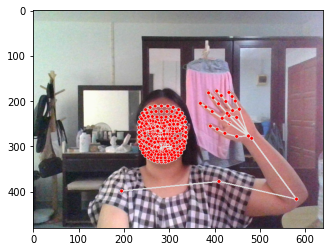

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

3. Extract Keypoint Values

In [13]:
len(results.left_hand_landmarks.landmark)

21

In [14]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [15]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)

In [16]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [17]:
result_test = extract_keypoints(results)

In [18]:
result_test

array([ 4.53058541e-01,  5.68924725e-01, -4.63423550e-01,  9.99978364e-01,
        4.71009880e-01,  5.25762200e-01, -4.10362810e-01,  9.99975681e-01,
        4.84800488e-01,  5.24270952e-01, -4.09828663e-01,  9.99974608e-01,
        4.98683602e-01,  5.23553193e-01, -4.09487873e-01,  9.99978602e-01,
        4.29043144e-01,  5.35264313e-01, -4.11544263e-01,  9.99967456e-01,
        4.15140331e-01,  5.39994240e-01, -4.10749763e-01,  9.99954760e-01,
        4.02521521e-01,  5.43896258e-01, -4.10809338e-01,  9.99953270e-01,
        5.14454663e-01,  5.44409335e-01, -1.18473276e-01,  9.99986112e-01,
        3.85033995e-01,  5.66568136e-01, -1.19875833e-01,  9.99968231e-01,
        4.85501528e-01,  6.23173177e-01, -3.61391872e-01,  9.99978304e-01,
        4.32057858e-01,  6.30843282e-01, -3.61125588e-01,  9.99961972e-01,
        6.41184568e-01,  7.86380053e-01, -2.82383617e-02,  9.99763429e-01,
        3.04996908e-01,  8.31226707e-01,  5.52723464e-03,  9.95506823e-01,
        9.08081353e-01,  

In [19]:
np.save('0', result_test)

In [20]:
np.load('0.npy')

array([ 4.53058541e-01,  5.68924725e-01, -4.63423550e-01,  9.99978364e-01,
        4.71009880e-01,  5.25762200e-01, -4.10362810e-01,  9.99975681e-01,
        4.84800488e-01,  5.24270952e-01, -4.09828663e-01,  9.99974608e-01,
        4.98683602e-01,  5.23553193e-01, -4.09487873e-01,  9.99978602e-01,
        4.29043144e-01,  5.35264313e-01, -4.11544263e-01,  9.99967456e-01,
        4.15140331e-01,  5.39994240e-01, -4.10749763e-01,  9.99954760e-01,
        4.02521521e-01,  5.43896258e-01, -4.10809338e-01,  9.99953270e-01,
        5.14454663e-01,  5.44409335e-01, -1.18473276e-01,  9.99986112e-01,
        3.85033995e-01,  5.66568136e-01, -1.19875833e-01,  9.99968231e-01,
        4.85501528e-01,  6.23173177e-01, -3.61391872e-01,  9.99978304e-01,
        4.32057858e-01,  6.30843282e-01, -3.61125588e-01,  9.99961972e-01,
        6.41184568e-01,  7.86380053e-01, -2.82383617e-02,  9.99763429e-01,
        3.04996908e-01,  8.31226707e-01,  5.52723464e-03,  9.95506823e-01,
        9.08081353e-01,  

4. Setup Folders for Collection

In [21]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Train_15word') 

# Actions that we try to detect
# array ของท่าทางภาษามือ
actions = np.array(['wait','ขอโทษที่มาสาย','คุณชื่ออะไร','คุณสบายดีไหม','ฉันสบายดี','แล้วพบกันใหม่',
'คุณกินข้าวหรือยัง','คุณอายุเท่าไหร่','ฉันกำลังจะกลับบ้าน','คุณจะกลับบ้านกี่โมง','คุณเหนื่อยไหม',
'ฉันไม่สบาย','พรุ่งนี้คุณจะไปไหน','ห้องน้ำไปทางไหน','ฉันกำลังทานข้าว','ไปกินข้าวด้วยกันไหม'])

# fifteen videos worth of data
# 15 video = 15 folder 
no_sequences = 30

# Videos are going to be 15 frames in length
# 15 ภาพ ใน 1 วิดีโอ
sequence_length = 30

# Folder start
start_folder = 30

In [22]:
# create folder data
for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
# หมวดที่ 1 >> 'Hello','Thank you','Sorry','Fine','Sick','Good luck','No problem','Yes','No','See you again'
## 'สวัสดี','ขอบคุณ','ขอโทษ','สบายดี','ไม่สบาย(ป่วย)','โชคดี','ไม่เป็นไร','ใช่','ไม่','พบกันใหม่'
# หมวดที่ 4 >> 'Clear soup','Noodles','Fried rice','Salad','Omelet','Papaya salad','Bread','Water','Cofee','Tea'
# หมวดที่ 7 >> '7-11','Big C','Shop','House','Hospital','School','Police station','Train station','Airport','Zoo'
# หมวดที่ 8 >> 'Daytime','Nighttime','Morning','Afternoon','Today','Tomorrow','Yesterday','Day','Month','Year'
# หมวดที่ 10 >> 'Pencil','Eraser','Notebook,'Book','T-shirt','Shoes','Skirt','Hairbrush','Earrings','Glasses'

# 'ขอโทษที่มาสาย','คุณชื่ออะไร','คุณสบายดีไหม','ฉันสบายดี','แล้วพบกันใหม่'

5. Collect Keypoint Values for Training and Testing

In [ ]:
#Training Data *ไม่ต้องรันซ้ำ*
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
       
                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)
                
                # Draw landmarks
                draw_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Show to screen
                cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(15) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
### 1 ไฟล์ = 1 เฟรมของวิดีโอ มี array ขนาด 1*258 (1 มิติ / 258 คือจุดบนมือ ใบหน้า และท่าทาง)
### ถ้า 1 วิดีโอมี 30 เฟรม = 30 ไฟล์ = มี array ขนาด 30*285 ???
npy = np.load('Train_Data/ขอโทษที่มาสาย/0/1.npy')

print('รูปร่างของ array คือ'), np.array(npy.shape) #จำนวนแถว คอลัมน์ (1-2 มิติ) ##จำนวนตาราง แถว คอลัมน์ (3 มิติ)
print('เป็น array กี่มิติ:', np.array(npy).ndim, 'มิติ') #ขนาดของ array กี่มิติ
print('จำนวนสมาชิกทั้งหมด คือ', np.array(npy).size) #จำนวนสมาชิกทั้งหมดใน array

In [ ]:
# array ขนาด 1*258 มิติ
np.load('Train_Data4/ขอโทษที่มาสาย/0/1.npy')

6. Preprocess Data and Create Labels and Features

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
label_map = {label:num for num, label in enumerate(actions)}

In [25]:
label_map

{'wait': 0,
 'ขอโทษที่มาสาย': 1,
 'คุณชื่ออะไร': 2,
 'คุณสบายดีไหม': 3,
 'ฉันสบายดี': 4,
 'แล้วพบกันใหม่': 5,
 'คุณกินข้าวหรือยัง': 6,
 'คุณอายุเท่าไหร่': 7,
 'ฉันกำลังจะกลับบ้าน': 8,
 'คุณจะกลับบ้านกี่โมง': 9,
 'คุณเหนื่อยไหม': 10,
 'ฉันไม่สบาย': 11,
 'พรุ่งนี้คุณจะไปไหน': 12,
 'ห้องน้ำไปทางไหน': 13,
 'ฉันกำลังทานข้าว': 14,
 'ไปกินข้าวด้วยกันไหม': 15}

In [26]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [27]:
np.array(sequences).shape

(480, 30, 258)

In [28]:
# จำนวนสมาชิกทั้งหมดใน array 
# 16 ท่าทาง 
print(np.array(sequences).size)

3715200


In [29]:
np.array(sequences).ndim

3

In [30]:
np.array(labels).shape

(480,)

In [31]:
X = np.array(sequences)

In [32]:
X.shape

(480, 30, 258)

In [33]:
y = to_categorical(labels).astype(int)

In [34]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# แบ่งข้อมูล train 70% : test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((336, 30, 258), (144, 30, 258), (336, 16), (144, 16))

7. Build and Train LSTM Neural Network

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [37]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [38]:
# Sequential api
model = Sequential()

model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(actions.shape[0], activation='softmax'))

#64,128,32 คือจำนวนโหนดของโมเดล
#input_shape=(15,258) >> 15 คือเฟรมรูป 258 คือจำนวน keypoint (จุดบนมือ+หน้า)


In [39]:
#จำนวนคำ/ประโยคที่เราเทรนเข้าไป
actions.shape[0]

16

In [40]:
res = [0.7, 0.2,0.1]

In [41]:
action[np.argmax(res)]
# 'Hello','Thank you','Sorry','Fine','Sick','Good luck','No problem','Yes','No','See you again'
## 'สวัสดี','ขอบคุณ','ขอโทษ','สบายดี','ไม่สบาย (ป่วย)','โชคดี','ไม่เป็นไร','ใช่','ไม่','พบกันใหม่'

'ไ'

In [42]:
# optimizer='Adam' คืออัลกอริทึมที่มาช่วยเพิ่มประสิทธิในการทำงานของโมเดล
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [43]:
# Train model
# epochs=800 คือจำนวนรอบในการเทรนโมเดล
# เทรนเพื่อนให้ค่า loss ลดลง (น้อยกว่า 0) และให้ค่า accuracy เพิ่มขึ้น (เข้าใกล้ 1)
# สร้างโฟลเดอร์ Logs ขึ้นมา
# ไม่ต้องเทรนทุกรอบก็ได้
model.fit(X_train, y_train, epochs=800, callbacks=[tb_callback])

Epoch 1/800
11/11 [==============================] - 5s 57ms/step - loss: 2.7508 - categorical_accuracy: 0.0685
Epoch 2/800
11/11 [==============================] - 1s 49ms/step - loss: 2.5700 - categorical_accuracy: 0.1845
Epoch 3/800
11/11 [==============================] - 1s 53ms/step - loss: 2.3545 - categorical_accuracy: 0.2024
Epoch 4/800
11/11 [==============================] - 1s 50ms/step - loss: 2.3149 - categorical_accuracy: 0.1964
Epoch 5/800
11/11 [==============================] - 1s 52ms/step - loss: 2.0939 - categorical_accuracy: 0.2679
Epoch 6/800
11/11 [==============================] - 1s 67ms/step - loss: 2.0219 - categorical_accuracy: 0.2649
Epoch 7/800
11/11 [==============================] - 1s 75ms/step - loss: 1.8503 - categorical_accuracy: 0.2530
Epoch 8/800
11/11 [==============================] - 1s 66ms/step - loss: 1.9137 - categorical_accuracy: 0.3006
Epoch 9/800
11/11 [==============================] - 1s 67ms/step - loss: 1.7998 - categorical_accuracy:

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
Total params: 237,680
Trainable params: 237,680
Non-trai

8. Make Predictions

In [45]:
res = model.predict(X_test)

5/5 [==============================] - 1s 17ms/step


In [46]:
actions[np.argmax(res[0])]

'ฉันกำลังจะกลับบ้าน'

In [47]:
actions[np.argmax(y_test[0])]

'ฉันกำลังจะกลับบ้าน'

9. Save Weights

In [48]:
model.save('action.h5')

In [49]:
model.load_weights('action.h5')

10. Evaluation using Confusion Matrix and Accuracy

In [50]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report

In [51]:
yhat = model.predict(X_test)

5/5 [==============================] - 0s 18ms/step


In [52]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [53]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[134,   0],
        [  0,  10]],

       [[135,   0],
        [  0,   9]],

       [[133,   0],
        [  0,  11]],

       [[135,   1],
        [  0,   8]],

       [[138,   0],
        [  0,   6]],

       [[136,   0],
        [  0,   8]],

       [[136,   0],
        [  0,   8]],

       [[137,   0],
        [  1,   6]],

       [[133,   2],
        [  0,   9]],

       [[133,   0],
        [  2,   9]],

       [[131,   0],
        [  1,  12]],

       [[134,   0],
        [  0,  10]],

       [[132,   2],
        [  0,  10]],

       [[138,   2],
        [  1,   3]],

       [[131,   1],
        [  2,  10]],

       [[133,   3],
        [  4,   4]]], dtype=int64)

In [54]:
confusion_matrix(ytrue, yhat)

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  9,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [55]:
print(classification_report(ytrue, yhat, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    1.0000    1.0000         9
           2     1.0000    1.0000    1.0000        11
           3     0.8889    1.0000    0.9412         8
           4     1.0000    1.0000    1.0000         6
           5     1.0000    1.0000    1.0000         8
           6     1.0000    1.0000    1.0000         8
           7     1.0000    0.8571    0.9231         7
           8     0.8182    1.0000    0.9000         9
           9     1.0000    0.8182    0.9000        11
          10     1.0000    0.9231    0.9600        13
          11     1.0000    1.0000    1.0000        10
          12     0.8333    1.0000    0.9091        10
          13     0.6000    0.7500    0.6667         4
          14     0.9091    0.8333    0.8696        12
          15     0.5714    0.5000    0.5333         8

    accuracy                         0.9236       144
   macro avg     0.9138   

In [56]:
#ความแม่นยำของข้อมูลที่ test ไป
accuracy_score(ytrue, yhat)

0.9236111111111112

11. Test in Real Time

In [57]:
#from scipy import stats
#from PIL import ImageFont
from PIL import Image, ImageFont, ImageDraw
from flask import Flask, render_template, Response

In [58]:
colors = [(245,117,16), (117,245,16), (16,117,245), (0,0,0),(138,43,226),
            (0,100,0),(255,0,0), (240,128,128), (139,69,19),(105,105,105),
            (255,0,0), (240,128,128), (139,69,19),(105,105,105)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # แถบสีที่ขึ้นบนข้อความแต่ละท่าทาง
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        # แถบข้อความด้านข้าง
        #cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # show thai lang
        
        fontpath = "./BaiJamjuree-Regular.ttf" 

        font =  ImageFont.truetype(fontpath,30)
        output_pil = Image.fromarray(output_frame)
        draw = ImageDraw.Draw(output_pil)
        text = draw.text((3, 52+num*40), actions[num], font = font, fill=(255,255,255))

        output_frame = np.array(output_pil) 
        
    return output_frame

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(prob_viz(res, actions, image, colors))

In [60]:
app = Flask(__name__)

## Demo Test ##

def generate():
    # 1. New detection variables
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.7

    #เปิดกล้องด้วย open cv
    cap = cv2.VideoCapture(0)

    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # while cap.isOpened():
        while True:

            # Read feed
            ret, frame = cap.read()
            
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            print(results)
                    
            # Draw landmarks
            draw_styled_landmarks(image, results)
                    
            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.insert(0,keypoints)
            #sequence.append(keypoints)
            sequence = sequence[:30]
                
                
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                        
                        
            #3. Viz logic
                if np.unique(predictions[-30:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold:   
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 3: 
                    sentence = sentence[-3:]

                    # Viz probabilities
                    #image = prob_viz(res, actions, image, colors)
                
            #Output Text    
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) 
            #cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            # show thai lang
            fontpath = "./BaiJamjuree-Regular.ttf" 

            font =  ImageFont.truetype(fontpath,30) #truetype(font,ขนาดของ font)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            text = draw.text((3,0), ' '.join(sentence), font = font, fill=(255,255,255)) 
            #(3,0) คือระยะห่างของแกน x,y ของข้อความ / fill คือ ใส่สีตัวอักษรแบบ RGB 

            image = np.array(img_pil)
                
            # Show to screen # ถ้าขึ้นเว็บไม่ต้องโชว์
            #cv2.imshow('OpenCV Feed', image)

            frame2 = cv2.imencode('.jpg', image)[1].tobytes()
            yield (b'--frame\r\n'b'Content-Type: image/jpeg\r\n\r\n' + frame2 + b'\r\n')

            # Break gracefully
            # if cv2.waitKey(10) & 0xFF == ord('q'):
            # if cv2.waitKey(1) == 27:
            #     break
            key = cv2.waitKey(20)
            if key == 27:
                break
        cap.release()
        cv2.destroyAllWindows()

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/video_feed')
def video_feed():
    return Response(generate(),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/about')
def about():
    return render_template('about.html')

if __name__=="__main__":
    app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [59]:
sequence = []
sentence = []
predictions = []
threshold = 0.7

In [60]:
cap.release()
cv2.destroyAllWindows()

In [61]:
res[np.argmax(res)] > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False])

In [ ]:
(sequences,30,1662)

In [59]:
model.predict(np.expand_dims(X_test[0],axis=0))

1/1 [==============================] - 0s 34ms/step


array([[9.5922374e-08, 7.4579890e-07, 9.9999869e-01, 3.1003890e-11,
        2.5400810e-08, 9.3350826e-13, 3.9618313e-25, 4.5129227e-08,
        3.6450643e-07, 5.3904087e-10, 9.6590888e-11, 1.0711628e-12,
        4.0415970e-14, 1.2010592e-14, 5.4052932e-11, 3.4176425e-19]],
      dtype=float32)

In [60]:
#ความแม่นยำของชุดข้อมูลการทดสอบ
(ls,acc)=model.evaluate(x=X_test,y=y_test)
print('MODEL ACCURACY = {}%'.format(acc*100))

5/5 [==============================] - 1s 17ms/step - loss: 0.8677 - categorical_accuracy: 0.9028
MODEL ACCURACY = 90.27777910232544%


In [61]:
#ความแม่นยำของชุดข้อมูลการฝึก
(ls,acc)=model.evaluate(x=X_train,y=y_train)
print('MODEL ACCURACY = {}%'.format(acc*100))

11/11 [==============================] - 0s 19ms/step - loss: 1.6822e-05 - categorical_accuracy: 1.0000
MODEL ACCURACY = 100.0%
